# Libraries

In [4]:
import numpy as np
import pandas as pd

import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid import ImageGrid

import time
import random
from tqdm.notebook import tqdm

plt.style.use("dark_background")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  


In [1]:
BASE_PATH= "/kaggle/input/lgg-mri-segmentation/kaggle_3m"

In [2]:
BASE_LEN = 89
END_LEN = 4
END_MASK_LEN = 9

IMG_SIZE = 512

# Get & Prepare Data

In [5]:
data = []

for dir_ in os.listdir(BASE_PATH):
    dir_path = os.path.join(BASE_PATH, dir_)
    if os.path.isdir(dir_path):
        for filename in os.listdir(dir_path):
            img_path = os.path.join(dir_path, filename)
            data.append([dir_, img_path])
    else:
        print(f"[INFO] This is not a dir --> {dir_path}")
        
df = pd.DataFrame(data, columns=["dir_name", "image_path"])

[INFO] This is not a dir --> /kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
[INFO] This is not a dir --> /kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv


In [6]:
df.head()

,dir_name,image_path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [6]:
df_imgs = df[~df["image_path"].str.contains("mask")]
df_masks = df[df["image_path"].str.contains("mask")]

In [7]:
imgs = sorted(df_imgs["image_path"].values, key= lambda x: int(x[BASE_LEN: -END_LEN]))
masks = sorted(df_masks["image_path"].values, key=lambda x: int(x[BASE_LEN: -END_MASK_LEN]))

In [8]:
# sanity check
idx = random.randint(0, len(imgs)-1)
print(f"This image *{imgs[idx]}*\n Belongs to the mask *{masks[idx]}*")

This image */kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_3.tif*
 Belongs to the mask */kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_3_mask.tif*


In [9]:
# final dataframe
dff = pd.DataFrame({"patient": df_imgs.dir_name.values,
                   "image_path": imgs,
                   "mask_path": masks})

dff.head()

,patient,image_path,mask_path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [10]:
def pos_neg_diagnosis(mask_path):
    val = np.max(cv2.imread(mask_path))
    if val > 0: return 1
    else: return 0

In [11]:
dff["diagnosis"] = dff["mask_path"].apply(lambda x: pos_neg_diagnosis(x))

dff.head()

,patient,image_path,mask_path,diagnosis
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0


In [14]:
dff.shape

(3929, 4)

In [15]:
print("Amount of patients: ", len(set(dff.patient)))
print("Amount of records: ", len(dff))

Amount of patients:  110
Amount of records:  3929


# EDA

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


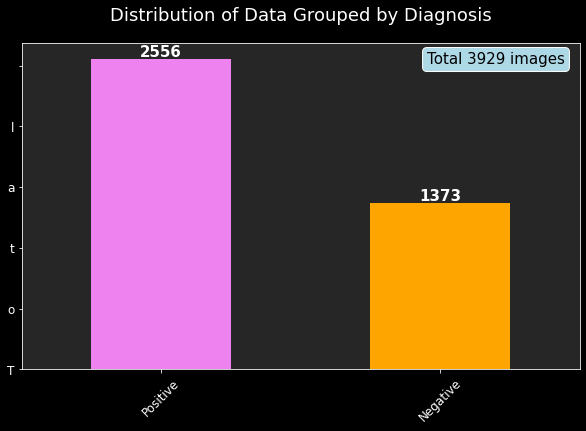

In [16]:
ax = dff.diagnosis.value_counts().plot(kind="bar",
                                stacked=True,
                                figsize=(10, 6),
                                color=["violet", "orange"])

ax.set_xticklabels(["Positive", "Negative"], rotation=45, fontsize=12)
ax.set_yticklabels("Total Images", fontsize=12)
ax.set_title("Distribution of Data Grouped by Diagnosis", fontsize=18, y=1.05)

for i, rows in enumerate(dff.diagnosis.value_counts().values):
    ax.annotate(int(rows), xy=(i, rows-12), 
                rotation=0, color="white", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")
    
ax.text(1.2, 2550, f"Total {len(dff)} images", size=15,
        color="black",
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   fc=("lightblue"),
         ))
ax.set_facecolor((0.15, 0.15, 0.15));

In [17]:
# returns how many diagnosed and non-diagnosed images each patient has
dff.groupby(["patient", "diagnosis"])["diagnosis"].size()

patient                diagnosis
TCGA_CS_4941_19960909  0            11
                       1            12
TCGA_CS_4942_19970222  0             8
                       1            12
TCGA_CS_4943_20000902  0             8
                                    ..
TCGA_HT_A616_19991226  1             4
TCGA_HT_A61A_20000127  0            71
                       1            17
TCGA_HT_A61B_19991127  0            62
                       1            26
Name: diagnosis, Length: 202, dtype: int64

In [18]:
patients_by_diagnosis = dff.groupby(["patient", "diagnosis"])["diagnosis"].size().unstack().fillna(0)
patients_by_diagnosis.columns = ["Positive", "Negative"]

patients_by_diagnosis.head()

,Positive,Negative
patient,,
TCGA_CS_4941_19960909,11.0,12.0
TCGA_CS_4942_19970222,8.0,12.0
TCGA_CS_4943_20000902,8.0,12.0
TCGA_CS_4944_20010208,17.0,3.0
TCGA_CS_5393_19990606,12.0,8.0


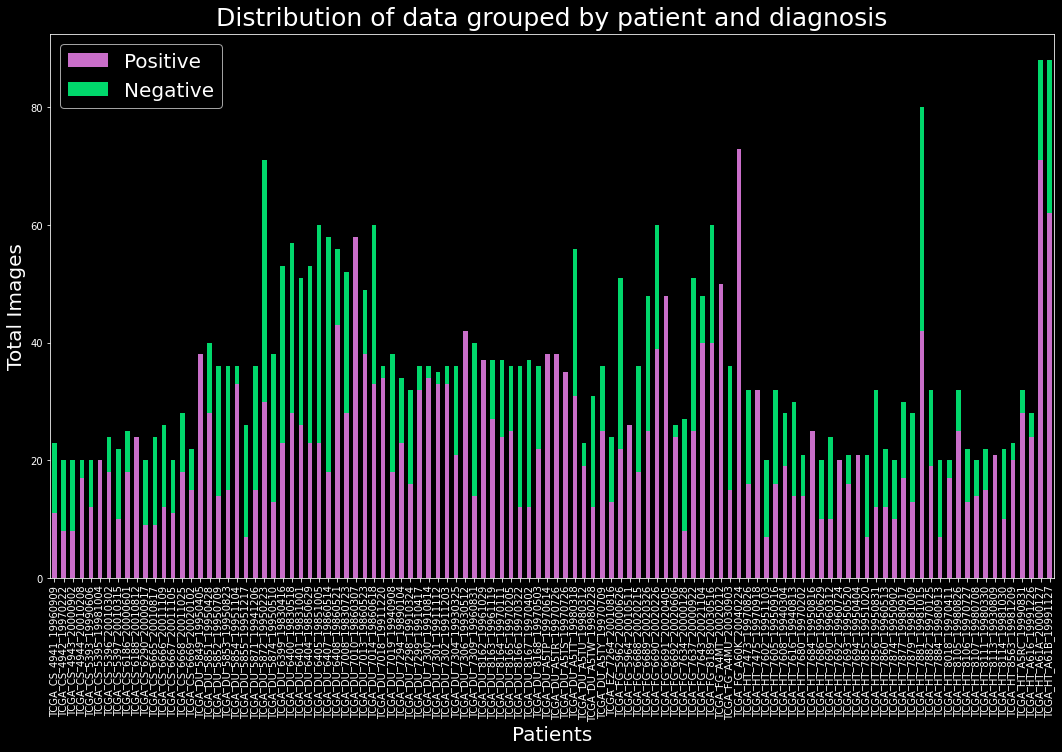

In [19]:
ax = patients_by_diagnosis.plot(kind="bar",
                          stacked=True,
                          figsize=(18,10),
                          color=["violet", "springgreen"],
                          alpha=0.85
                          )
ax.legend(fontsize=20, loc="upper left")
ax.grid(False)
ax.set_xlabel('Patients',fontsize = 20)
ax.set_ylabel('Total Images', fontsize = 20)
ax.set_title("Distribution of data grouped by patient and diagnosis",fontsize = 25, y=1.005);

# Visualize Data

In [20]:
sample_pos = dff[dff["diagnosis"] == 1].sample(5).image_path.values
sample_neg = dff[dff["diagnosis"] == 0].sample(5).image_path.values

sample_imgs = []

for i, (pos, neg) in enumerate(zip(sample_pos, sample_neg)):
    pos = cv2.resize(cv2.imread(pos), (IMG_SIZE, IMG_SIZE))
    neg = cv2.resize(cv2.imread(neg), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([pos, neg])
    
sample_yes_arr = np.vstack(np.array(sample_imgs[::2]))
sample_no_arr = np.vstack(np.array(sample_imgs[1::2]))

In [21]:
sample_yes_arr.shape

(2560, 512, 3)

In [23]:
# masks
sample_df = dff[dff["diagnosis"] == 1].sample(5).values

sample_imgs = []

for i, data in enumerate(sample_df):
    img = cv2.resize(cv2.imread(data[1]), (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(cv2.imread(data[2]), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([img, mask])

In [24]:
sample_img_arr = np.hstack(sample_imgs[::2])
sample_mask_arr = np.hstack(sample_imgs[1::2])

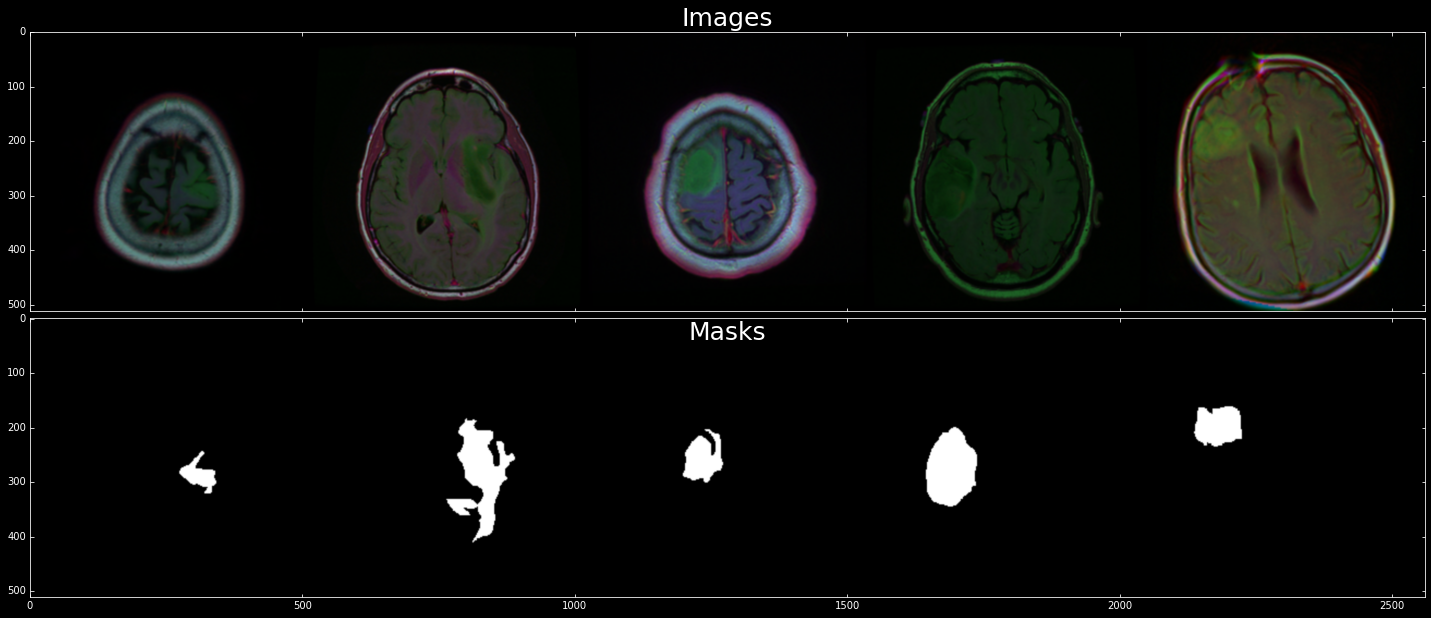

In [25]:
# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 1),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_img_arr)
grid[0].set_title("Images", fontsize=25)
grid[0].axis("off")
grid[0].grid(False)

grid[1].imshow(sample_mask_arr)
grid[1].set_title("Masks", fontsize=25, y=0.9)
grid[1].axis("off")
grid[1].grid(False)

plt.show()

# Data Augmentation and Loader

In [12]:
!pip install albumentations==0.4.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 2.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=2f17a9ff26bd1bb3b8591714976128f635b6fb099cfcdf2afba57d1f8ff2f1a2
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.3.0
    Uninstalling albumentations-1.3.0:
      Successfully uninstalled albumentations-1.3.0


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import albumentations.augmentations.transforms as AT
from albumentations.pytorch import ToTensorV2, ToTensor

from sklearn.model_selection import train_test_split

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [46]:
class BrainMRIDataset:
    def __init__(self, df, transforms):
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 1])
        mask = cv2.imread(self.df.iloc[idx, 2], 0)
        
        augmented = self.transforms(image=image,
                                   mask=mask)
        
        image = augmented["image"]
        mask = augmented["mask"]
        
        return image, mask

In [47]:
PATCH_SIZE = 128

strong_transforms = A.Compose([
    A.RandomResizedCrop(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),

    AT.CLAHE(p=0.5),
    AT.ChannelShuffle(p=0.25),
    AT.RandomBrightness(p=0.2),
    
    # Pixels
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.25),
    A.Blur(p=0.01, blur_limit = 3),
    
    # Affine
    A.OneOf([
        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5),
    ], p=0.8),
    
    
    A.Normalize(p=1.0),
    ToTensor(),
])


transforms = A.Compose([
    A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),

    A.Normalize(p=1.0),
    ToTensor(),
    
])

In [48]:
train_df, val_df = train_test_split(dff, stratify=dff.diagnosis, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.12)
train_df = train_df.reset_index(drop=True)

print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3111, 4) 
Val: (393, 4) 
Test: (425, 4)


In [49]:
train_dataset = BrainMRIDataset(train_df, transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=26, num_workers=2, shuffle=True)

val_dataset = BrainMRIDataset(val_df, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=26, num_workers=2, shuffle=True)

test_dataset = BrainMRIDataset(test_df, transforms=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=26, num_workers=2, shuffle=True)

In [21]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

3111
393
425


In [50]:
def show_aug(inputs, nrows=5, ncols=5, norm=True):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i_ = 0
    
    if len(inputs) > 25:
        inputs = inputs[:25]
        
    for idx in range(len(inputs)):
    
        # normalization
        if norm:           
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225] 
            img = (img*std+mean).astype(np.float32)
            
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]
        
        plt.subplot(nrows, ncols, i_+1)
        if len(img.shape) < 3:
            plt.imshow(img, cmap="gray")
        else:
            plt.imshow(img); 
        plt.axis('off')
 
        i_ += 1
        
    return plt.show()

In [52]:
images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

show_aug(images)
show_aug(masks, norm=False)

# Models

# U-Net

In [35]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, 3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(out_channels, out_channels, 3, padding=1),
    nn.ReLU(inplace=True))

In [36]:
class UNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
                
        self.conv_down1 = double_conv(3, 64)
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.conv_up3 = double_conv(256 + 512, 256)
        self.conv_up2 = double_conv(128 + 256, 128)
        self.conv_up1 = double_conv(128 + 64, 64)
        
        self.last_conv = nn.Conv2d(64, n_classes, kernel_size=1)
        
        
    def forward(self, x):
        conv1 = self.conv_down1(x)  
        x = self.maxpool(conv1)    
        
        conv2 = self.conv_down2(x) 
        x = self.maxpool(conv2)    
        
        conv3 = self.conv_down3(x)  
        x = self.maxpool(conv3)     
        
        x = self.conv_down4(x)      
        x = self.upsample(x)        
        
        x = torch.cat([x, conv3], dim=1) 
        
        x = self.conv_up3(x) 
        x = self.upsample(x) 
        
        x = torch.cat([x, conv2], dim=1) 

        x = self.conv_up2(x)
        x = self.upsample(x)   
        
        x = torch.cat([x, conv1], dim=1)
        
        x = self.conv_up1(x)
        
        out = self.last_conv(x)
        out = torch.sigmoid(out)
        
        return out

In [37]:
unet = UNet(n_classes=1).to(device)

In [38]:
output = torch.randn(1,3,256,256).to(device)
output.shape

torch.Size([1, 3, 256, 256])

# FPN

In [39]:
class ConvReluUpsample(nn.Module):
    def __init__(self, in_channels, out_channels, upsample=False):
        super().__init__()
        self.upsample = upsample
        self.make_upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, (3,3), stride=1, padding=1, bias=False),
        nn.GroupNorm(32, out_channels),
        nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        x = self.block(x)
        if self.upsample:
            x = self.make_upsample(x)
        return x
    
class SegmentationBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_upsamples=0):
        super().__init__()
        
        blocks = [ConvReluUpsample(in_channels, out_channels, upsample=bool(n_upsamples))]
        
        if n_upsamples > 1:
            for _ in range(1, n_upsamples):
                blocks.append(ConvReluUpsample(out_channels, out_channels, upsample=True))
                
        self.block = nn.Sequential(*blocks)
    
    def forward(self, x):
        return self.block(x)

In [40]:
class FPN(nn.Module):
    def __init__(self, n_classes=1, pyramid_channels=256,
                segmentation_channels=256):
        super().__init__()
        
        self.conv_down1 = double_conv(3, 64)
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512)
        self.conv_down5 = double_conv(512, 1024)
        self.maxpool = nn.MaxPool2d(2)
        
        self.toplayer = nn.Conv2d(1024, 256, kernel_size=1, stride=1, padding=0)
        
        self.smooth1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        
        self.latlayer1 =nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer2 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer3 = nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=0)
        
        self.seg_blocks = nn.ModuleList([
            SegmentationBlock(pyramid_channels, segmentation_channels,
                             n_upsamples=n_upsamples) for n_upsamples in [0, 1, 2, 3]
        ])
        
        self.last_conv = nn.Conv2d(256, n_classes, kernel_size=1, stride=1, padding=0)
        
    def upsample_add(self, x, y):
        _, _, h, w = y.size()
        sample = nn.Upsample(size=(h, w), mode="bilinear", align_corners=True)
        return sample(x)+y
    
    def upsample(self, x, h, w):
        sample = nn.Upsample(size=(h, w), mode="bilinear", align_corners=True)
        return sample(x)
        
    def forward(self, x):
        c1 = self.maxpool(self.conv_down1(x))
        c2 = self.maxpool(self.conv_down2(c1))
        c3 = self.maxpool(self.conv_down3(c2))
        c4 = self.maxpool(self.conv_down4(c3))
        c5 = self.maxpool(self.conv_down5(c4))
        
        p5 = self.toplayer(c5)
        p4 = self.upsample_add(p5, self.latlayer1(c4))
        p3 = self.upsample_add(p4, self.latlayer2(c3))
        p2 = self.upsample_add(p3, self.latlayer3(c2))
        
        p4 = self.smooth1(p4)
        p3 = self.smooth2(p3)
        p2 = self.smooth3(p2)
        
        _, _, h, w = p2.size()
        feature_pyramid = [seg_block(p) for seg_block, p in zip(self.seg_blocks, [p2, p3, p4, p5])]
        
        out = self.upsample(self.last_conv(sum(feature_pyramid)), 4*h, 4*w)
        out = torch.sigmoid(out)
        return out

In [41]:
fpn = FPN().to(device)
output = fpn(torch.randn(1,3,256,256).to(device))
print(output.shape)

torch.Size([1, 1, 256, 256])


# UNet with ResNet Backbone

In [42]:
from torchvision.models import resnext50_32x4d

class ConvRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, padding):
        super().__init__()
        
        self.convrelu = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        x = self.convrelu(x)
        return x
    
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = ConvRelu(in_channels, in_channels//4, 1, 0)
        
        self.deconv = nn.ConvTranspose2d(in_channels//4, in_channels//4,
                                         kernel_size=4, stride=2,
                                        padding=1, output_padding=0)
        self.conv2 = ConvRelu(in_channels//4, out_channels, 1, 0)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.deconv(x)
        x = self.conv2(x)
        
        return x

In [43]:
class ResNeXtUNet(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
        
        self.base_model = resnext50_32x4d(pretrained=True)
        self.base_layers = list(self.base_model.children())
        filters = [4*64, 4*128, 4*256, 4*512]
        
        self.encoder0 = nn.Sequential(*self.base_layers[:3])
        self.encoder1 = nn.Sequential(*self.base_layers[4])
        self.encoder2 = nn.Sequential(*self.base_layers[5])
        self.encoder3 = nn.Sequential(*self.base_layers[6])
        self.encoder4 = nn.Sequential(*self.base_layers[7])
        
        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])
        
        self.last_conv0 = ConvRelu(256, 128, 3, 1)
        self.last_conv1 = nn.Conv2d(128, n_classes, 3, padding=1)
        
    def forward(self, x):
        x = self.encoder0(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)
        
        out = self.last_conv0(d1)
        out = self.last_conv1(out)
        
        out = torch.sigmoid(out)
        
        return out

In [44]:
resnextunet = ResNeXtUNet().to(device)
output = resnextunet(torch.randn(1,3,256,256).to(device))
print(output.shape)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

torch.Size([1, 1, 256, 256])


# Segmentation Metric

In [45]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target*inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0 
    return intersection/union

# Segmentation Loss

In [46]:
def dice_coef_loss(inputs, target):
    smooth = 1.0 
    intersection = 2.0 * (target*inputs).sum() + smooth
    union = target.sum() + inputs.sum() + smooth
    return 1 - (intersection/union)

def bce_dice_loss(inputs, target):
    dice_score = dice_coef_loss(inputs, target)
    bce_loss = nn.BCELoss()
    bce_score = bce_loss(inputs, target)
    
    return bce_score + dice_score

In [47]:
# sanity check
bce_dice_loss(torch.tensor([0.7, 1., 1.]), 
              torch.tensor([1.,1.,1.]))

tensor(0.1637)

# Early Stopping

In [48]:
# early stopping
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

In [49]:
early_stopping = EarlyStopping(tolerance=5, min_delta=10)

# Training

In [50]:
def train_model(model_name, model, train_loader, val_loader, train_loss, optimizer, lr_scheduler, num_epochs):
    print(f"[INFO] Model is initializing... {model_name}")
    
    loss_history = []
    train_history = []
    val_history = []
        
    for epoch in range(num_epochs):
        
        model.train()
        
        losses = []
        train_iou = []
        
        if lr_scheduler:
            warmup_factor = 1.0 / 100
            warmup_iters = min(100, len(train_loader) - 1)
            lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)
        
        for i_step, (data, target) in enumerate(tqdm(train_loader)):
            data = data.to(device)
            target = target.to(device)
            
            
            outputs = model(data)
            
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            train_dice = dice_coef_metric(out_cut, target.data.cpu().numpy())
            
            loss = train_loss(outputs, target)
            
            losses.append(loss.item())
            train_iou.append(train_dice)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            if lr_scheduler:
                lr_scheduler.step()
                
        val_mean_iou = compute_iou(model, val_loader)
        
        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())
        val_history.append(val_mean_iou)
        
        # early stopping
        early_stopping(np.array(losses).mean(), val_mean_iou)
        if early_stopping.early_stop:
            print("[INFO] Early stopping at epoch:", i)
            break
        
        print("Epoch [%d]" % (epoch))
        print("Mean loss on train:", np.array(losses).mean(), 
              "\nMean DICE on train:", np.array(train_iou).mean(), 
              "\nMean DICE on validation:", val_mean_iou)
        
    return loss_history, train_history, val_history

In [51]:
def compute_iou(model, loader, threshold=0.3):
    valloss = 0
    
    with torch.no_grad():

        for i_step, (data, target) in enumerate(loader):
            
            data = data.to(device)
            target = target.to(device)
            
            outputs = model(data)

            out_cut = np.copy(outputs.data.cpu().detach())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            picloss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss += picloss

    return valloss / i_step

In [52]:
# lr_scheduler
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

## Train UNet

In [53]:
unet_optimizer = torch.optim.Adamax(unet.parameters(), weight_decay=1e-3)

In [54]:
%%time
num_ep = 50

unet_lh, unet_th, unet_vh = train_model("Vanilla_UNet", unet, train_dataloader, val_dataloader, bce_dice_loss, unet_optimizer, False, num_ep)

[INFO] Model is initializing... Vanilla_UNet


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [0]
Mean loss on train: 0.6925969985624154 
Mean DICE on train: 0.38333976394728564 
Mean DICE on validation: 0.5679333867446825


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [1]
Mean loss on train: 0.611714048931996 
Mean DICE on train: 0.46878496232841077 
Mean DICE on validation: 0.6097449218649905


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [2]
Mean loss on train: 0.54480784672002 
Mean DICE on train: 0.5218222376967313 
Mean DICE on validation: 0.6424589782793951


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [3]
Mean loss on train: 0.5241226111849149 
Mean DICE on train: 0.5401598069294905 
Mean DICE on validation: 0.665785039410499


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [4]
Mean loss on train: 0.4909869064887365 
Mean DICE on train: 0.5661424480169366 
Mean DICE on validation: 0.6856803842209179


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [5]
Mean loss on train: 0.46898235318561393 
Mean DICE on train: 0.5853840037237223 
Mean DICE on validation: 0.6617708073251323


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [6]
Mean loss on train: 0.46493803039193154 
Mean DICE on train: 0.5894978291675683 
Mean DICE on validation: 0.590274617415793


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [7]
Mean loss on train: 0.46212418377399445 
Mean DICE on train: 0.594183409654857 
Mean DICE on validation: 0.7196905239265784


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [8]
Mean loss on train: 0.4205824642131726 
Mean DICE on train: 0.6300362544904632 
Mean DICE on validation: 0.6534161249198484


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [9]
Mean loss on train: 0.3977954516808192 
Mean DICE on train: 0.6508186574878699 
Mean DICE on validation: 0.7570186440379243


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [10]
Mean loss on train: 0.4033573848505815 
Mean DICE on train: 0.6459027827667937 
Mean DICE on validation: 0.7210887511126528


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [11]
Mean loss on train: 0.38324351074794927 
Mean DICE on train: 0.6622880037379564 
Mean DICE on validation: 0.7383118543541304


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [12]
Mean loss on train: 0.36466625034809114 
Mean DICE on train: 0.6794702561798981 
Mean DICE on validation: 0.7464000528641183


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [13]
Mean loss on train: 0.37756153469284376 
Mean DICE on train: 0.6679401208685161 
Mean DICE on validation: 0.7536948589137211


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [14]
Mean loss on train: 0.35343722589313986 
Mean DICE on train: 0.6893423900473797 
Mean DICE on validation: 0.7387364087407126


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [15]
Mean loss on train: 0.3498984660953283 
Mean DICE on train: 0.6914030603114633 
Mean DICE on validation: 0.6908190112191924


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [16]
Mean loss on train: 0.33920064978301523 
Mean DICE on train: 0.7010043439810398 
Mean DICE on validation: 0.7934531467440977


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [17]
Mean loss on train: 0.34203999638557436 
Mean DICE on train: 0.6995083062153014 
Mean DICE on validation: 0.7933304819894329


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [18]
Mean loss on train: 0.3316826627900203 
Mean DICE on train: 0.7083251147888394 
Mean DICE on validation: 0.767887910275896


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [19]
Mean loss on train: 0.3321173032124837 
Mean DICE on train: 0.7088837150319799 
Mean DICE on validation: 0.6929630964687572


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [20]
Mean loss on train: 0.3378574808438619 
Mean DICE on train: 0.7027520331900767 
Mean DICE on validation: 0.741795035981354


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [21]
Mean loss on train: 0.3218068938702345 
Mean DICE on train: 0.7158177269057202 
Mean DICE on validation: 0.7565645758516192


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [22]
Mean loss on train: 0.30233735715349513 
Mean DICE on train: 0.7342243673158604 
Mean DICE on validation: 0.806107852507947


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [23]
Mean loss on train: 0.3205765807380279 
Mean DICE on train: 0.7168102009360372 
Mean DICE on validation: 0.8301522136691438


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [24]
Mean loss on train: 0.3321652304381132 
Mean DICE on train: 0.707022502070289 
Mean DICE on validation: 0.7966649147272633


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [25]
Mean loss on train: 0.30215141009539365 
Mean DICE on train: 0.7349809558835362 
Mean DICE on validation: 0.8199541750588426


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [26]
Mean loss on train: 0.283924774825573 
Mean DICE on train: 0.7503677851832834 
Mean DICE on validation: 0.8335982426485948


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [27]
Mean loss on train: 0.2921446024129788 
Mean DICE on train: 0.7423263289379733 
Mean DICE on validation: 0.8329694226104861


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [28]
Mean loss on train: 0.3006761328006784 
Mean DICE on train: 0.7357594193970797 
Mean DICE on validation: 0.7872354157682937


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [29]
Mean loss on train: 0.2970570314054688 
Mean DICE on train: 0.7392057494279173 
Mean DICE on validation: 0.8340079110434734


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [30]
Mean loss on train: 0.29934569243341685 
Mean DICE on train: 0.7370461374092027 
Mean DICE on validation: 0.8438834984960278


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [31]
Mean loss on train: 0.26524221965422234 
Mean DICE on train: 0.7676127924800902 
Mean DICE on validation: 0.8422902901107356


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [32]
Mean loss on train: 0.2699689781293273 
Mean DICE on train: 0.7622675495721382 
Mean DICE on validation: 0.8467078508647192


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [33]
Mean loss on train: 0.26759981097032626 
Mean DICE on train: 0.7658987846775003 
Mean DICE on validation: 0.8580568016935604


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [34]
Mean loss on train: 0.2743863746523857 
Mean DICE on train: 0.7596728668157451 
Mean DICE on validation: 0.8454386393188749


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [35]
Mean loss on train: 0.2598399726053079 
Mean DICE on train: 0.7716709315117422 
Mean DICE on validation: 0.840332080827505


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [36]
Mean loss on train: 0.2682764781018098 
Mean DICE on train: 0.7633500463451395 
Mean DICE on validation: 0.7594187288381814


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [37]
Mean loss on train: 0.2594163196161389 
Mean DICE on train: 0.7720298849502327 
Mean DICE on validation: 0.8717133774005593


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [38]
Mean loss on train: 0.2597616283843915 
Mean DICE on train: 0.7707542339710899 
Mean DICE on validation: 0.8650477435215863


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [39]
Mean loss on train: 0.2592993617678682 
Mean DICE on train: 0.7718893299588881 
Mean DICE on validation: 0.8388645199964224


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [40]
Mean loss on train: 0.24995818144331375 
Mean DICE on train: 0.7793926890868587 
Mean DICE on validation: 0.8444386357554202


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [41]
Mean loss on train: 0.2588579601297776 
Mean DICE on train: 0.771736397639945 
Mean DICE on validation: 0.828841758666151


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [44]
Mean loss on train: 0.2270553193986416 
Mean DICE on train: 0.8003418992100663 
Mean DICE on validation: 0.8871360148789526


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [45]
Mean loss on train: 0.24761660775790612 
Mean DICE on train: 0.7819152564237944 
Mean DICE on validation: 0.8669903030182046


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [46]
Mean loss on train: 0.2347501424451669 
Mean DICE on train: 0.7931368151059527 
Mean DICE on validation: 0.856208992841285


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [47]
Mean loss on train: 0.2157099772244692 
Mean DICE on train: 0.8098980729969725 
Mean DICE on validation: 0.8867913734288421


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [48]
Mean loss on train: 0.22074547267208497 
Mean DICE on train: 0.805292181770064 
Mean DICE on validation: 0.8710942604620902


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [49]
Mean loss on train: 0.22346002229799827 
Mean DICE on train: 0.803851948264034 
Mean DICE on validation: 0.8091423857647558
CPU times: user 44min 53s, sys: 42.4 s, total: 45min 36s
Wall time: 47min 3s


In [55]:
def plot_model_history(model_name,
                        train_history, val_history, 
                        num_epochs):
    
    x = np.arange(num_epochs)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_history, label='train dice', lw=3, c="springgreen")
    plt.plot(x, val_history, label='validation dice', lw=3, c="deeppink")

    plt.title(f"{model_name}", fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    fn = str(int(time.time())) + ".png"
    plt.show()

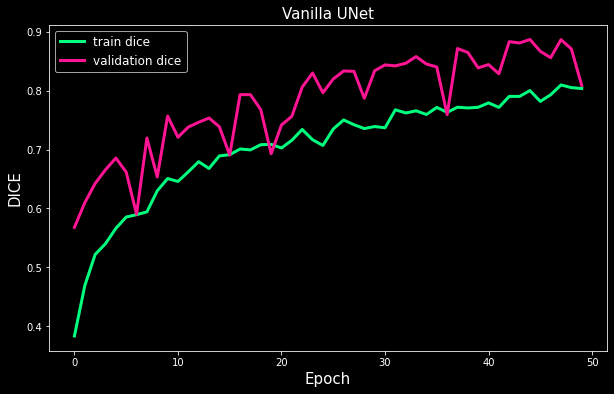

In [56]:
plot_model_history("Vanilla UNet", unet_th, unet_vh, num_ep)

# Train FPN

In [57]:
fpn_optimizer = torch.optim.Adamax(fpn.parameters(), weight_decay=1e-3)

In [58]:
%%time
num_ep = 50

fpn_lh, fpn_th, fpn_vh = train_model("FPN", fpn, train_dataloader, val_dataloader, bce_dice_loss, fpn_optimizer, False, num_ep)

[INFO] Model is initializing... FPN


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [0]
Mean loss on train: 1.00675305078427 
Mean DICE on train: 0.00046086287736177924 
Mean DICE on validation: 0.06666666666666667


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [1]
Mean loss on train: 0.9652061974008878 
Mean DICE on train: 0.056389071716325435 
Mean DICE on validation: 0.17362153852792


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [2]
Mean loss on train: 0.7125170481701691 
Mean DICE on train: 0.36954764901463044 
Mean DICE on validation: 0.5825405700819559


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [3]
Mean loss on train: 0.515663922081391 
Mean DICE on train: 0.5583005825592853 
Mean DICE on validation: 0.6642312381217994


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [4]
Mean loss on train: 0.48911263967553775 
Mean DICE on train: 0.5782663096259708 
Mean DICE on validation: 0.6312726232611046


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [5]
Mean loss on train: 0.46856553070247176 
Mean DICE on train: 0.5937356016280285 
Mean DICE on validation: 0.6995661117057684


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [6]
Mean loss on train: 0.4523248163362344 
Mean DICE on train: 0.6064590462637587 
Mean DICE on validation: 0.7068588373319821


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [7]
Mean loss on train: 0.45327311965326467 
Mean DICE on train: 0.6045655757914202 
Mean DICE on validation: 0.6492808098212813


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [8]
Mean loss on train: 0.44279259045918784 
Mean DICE on train: 0.6134233702690267 
Mean DICE on validation: 0.6832225268056824


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [9]
Mean loss on train: 0.40330788207550844 
Mean DICE on train: 0.6494694796115056 
Mean DICE on validation: 0.7163501471516162


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [10]
Mean loss on train: 0.40465695336461066 
Mean DICE on train: 0.6485312178589259 
Mean DICE on validation: 0.7405383006228995


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [11]
Mean loss on train: 0.3912982452660799 
Mean DICE on train: 0.66013421050807 
Mean DICE on validation: 0.7452805196102509


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [12]
Mean loss on train: 0.3845033248265584 
Mean DICE on train: 0.6646131826743585 
Mean DICE on validation: 0.7171375355699428


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [13]
Mean loss on train: 0.3947424441576004 
Mean DICE on train: 0.6554967125658716 
Mean DICE on validation: 0.7272896330173206


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [14]
Mean loss on train: 0.3685782873382171 
Mean DICE on train: 0.6799978184842395 
Mean DICE on validation: 0.71618982509736


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [15]
Mean loss on train: 0.37133593671023846 
Mean DICE on train: 0.6779057275966761 
Mean DICE on validation: 0.6638071754193116


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [16]
Mean loss on train: 0.36277999641994635 
Mean DICE on train: 0.6843048027081949 
Mean DICE on validation: 0.7332049592749177


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [17]
Mean loss on train: 0.36752047737439475 
Mean DICE on train: 0.6805711781748417 
Mean DICE on validation: 0.666298798933371


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [18]
Mean loss on train: 0.35098239618043103 
Mean DICE on train: 0.6966211268028639 
Mean DICE on validation: 0.7589851349569808


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [19]
Mean loss on train: 0.3536212511360645 
Mean DICE on train: 0.6924257437592568 
Mean DICE on validation: 0.7136297690040968


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [20]
Mean loss on train: 0.33696371701856453 
Mean DICE on train: 0.7089676416117636 
Mean DICE on validation: 0.7788767538585388


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [21]
Mean loss on train: 0.3412691748390595 
Mean DICE on train: 0.704635324158775 
Mean DICE on validation: 0.7161786722339162


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [22]
Mean loss on train: 0.33648112540443736 
Mean DICE on train: 0.7088826296803359 
Mean DICE on validation: 0.7376925855451586


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [26]
Mean loss on train: 0.31817997619509697 
Mean DICE on train: 0.724145829473787 
Mean DICE on validation: 0.7614435121752023


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [27]
Mean loss on train: 0.3010695663591226 
Mean DICE on train: 0.7413866203907754 
Mean DICE on validation: 0.797392801845362


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [28]
Mean loss on train: 0.3009832895050446 
Mean DICE on train: 0.7394156296246108 
Mean DICE on validation: 0.808054432438666


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [29]
Mean loss on train: 0.3079446976383527 
Mean DICE on train: 0.7334580989879084 
Mean DICE on validation: 0.800375741206789


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [30]
Mean loss on train: 0.2995225561782718 
Mean DICE on train: 0.7411407394789092 
Mean DICE on validation: 0.7440309588657386


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [31]
Mean loss on train: 0.29215610946218173 
Mean DICE on train: 0.7477390115244457 
Mean DICE on validation: 0.7586621436251141


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [32]
Mean loss on train: 0.2860726973662774 
Mean DICE on train: 0.7526022548583242 
Mean DICE on validation: 0.7887031110303971


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [33]
Mean loss on train: 0.2903967457513014 
Mean DICE on train: 0.7493825825363539 
Mean DICE on validation: 0.8173821573684726


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [34]
Mean loss on train: 0.28913698891798656 
Mean DICE on train: 0.7505704912907126 
Mean DICE on validation: 0.8043526383252403


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [35]
Mean loss on train: 0.27025215327739716 
Mean DICE on train: 0.7680119230650867 
Mean DICE on validation: 0.8086872983451602


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [36]
Mean loss on train: 0.2752253025770187 
Mean DICE on train: 0.7624570588792015 
Mean DICE on validation: 0.8331125052542389


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [37]
Mean loss on train: 0.26914025396108626 
Mean DICE on train: 0.7687383820143318 
Mean DICE on validation: 0.8139397780094693


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [38]
Mean loss on train: 0.2751570846885443 
Mean DICE on train: 0.7625638980036065 
Mean DICE on validation: 0.7869938383989304


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [39]
Mean loss on train: 0.28291270894308884 
Mean DICE on train: 0.7555786975236718 
Mean DICE on validation: 0.8093271823768876


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [40]
Mean loss on train: 0.26400552249203124 
Mean DICE on train: 0.7726718426428161 
Mean DICE on validation: 0.8479111294744892


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [41]
Mean loss on train: 0.2730317339921991 
Mean DICE on train: 0.764625929913223 
Mean DICE on validation: 0.8016052887181654


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [42]
Mean loss on train: 0.2645136998345455 
Mean DICE on train: 0.7704184371837558 
Mean DICE on validation: 0.8357151308404839


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [43]
Mean loss on train: 0.2521646408985058 
Mean DICE on train: 0.7821641602363288 
Mean DICE on validation: 0.8147201330087669


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [44]
Mean loss on train: 0.25728784228364626 
Mean DICE on train: 0.7779262236968605 
Mean DICE on validation: 0.8334658508245739


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [45]
Mean loss on train: 0.2516199808567762 
Mean DICE on train: 0.7822691373875301 
Mean DICE on validation: 0.8350676766175202


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [46]
Mean loss on train: 0.2551023904234171 
Mean DICE on train: 0.778574313811585 
Mean DICE on validation: 0.8349395287565393


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [47]
Mean loss on train: 0.24675992466509342 
Mean DICE on train: 0.7868161525134556 
Mean DICE on validation: 0.8104267783815161


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [48]
Mean loss on train: 0.2468744042639931 
Mean DICE on train: 0.7873541262465675 
Mean DICE on validation: 0.8629959669023858


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [49]
Mean loss on train: 0.25247874135772386 
Mean DICE on train: 0.7826365551666896 
Mean DICE on validation: 0.7276964163966327
CPU times: user 30min 4s, sys: 41.9 s, total: 30min 46s
Wall time: 32min 4s


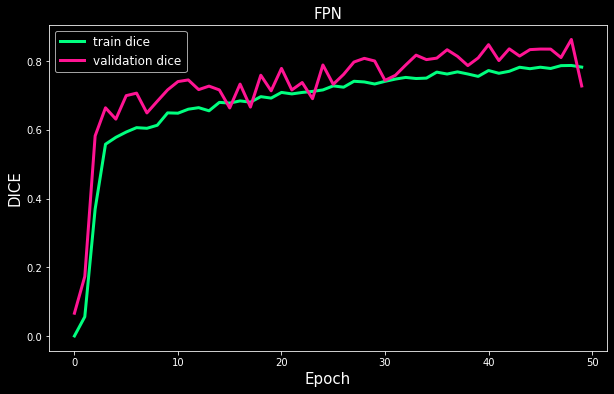

In [59]:
plot_model_history("FPN", fpn_th, fpn_vh, num_ep)

# Training: ResNeXt-UNet

In [60]:
resnextunet_optimizer = torch.optim.Adamax(resnextunet.parameters(), weight_decay=1e-3)

In [61]:
%%time
num_ep = 50

resnextunet_lh, resnextunet_th, resnextunet_vh = train_model("ResNeXtUNet", resnextunet, train_dataloader, val_dataloader, bce_dice_loss, resnextunet_optimizer, False, num_ep)

[INFO] Model is initializing... ResNeXtUNet


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [0]
Mean loss on train: 0.6593819289157788 
Mean DICE on train: 0.3967563271014026 
Mean DICE on validation: 0.7078600462599086


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [1]
Mean loss on train: 0.4109847955405712 
Mean DICE on train: 0.6358549861328281 
Mean DICE on validation: 0.6950025610469553


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [2]
Mean loss on train: 0.35927101174990334 
Mean DICE on train: 0.6831056452640134 
Mean DICE on validation: 0.7515296450783641


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [3]
Mean loss on train: 0.32127655247847237 
Mean DICE on train: 0.7168427823739615 
Mean DICE on validation: 0.7624323163574888


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [4]
Mean loss on train: 0.2860282603651285 
Mean DICE on train: 0.7486145679815325 
Mean DICE on validation: 0.8428004368482027


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [5]
Mean loss on train: 0.27027124147862197 
Mean DICE on train: 0.7607619192712641 
Mean DICE on validation: 0.798047467143713


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [6]
Mean loss on train: 0.2626935051133235 
Mean DICE on train: 0.7683494985992767 
Mean DICE on validation: 0.8035834055913391


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [7]
Mean loss on train: 0.24157351373384398 
Mean DICE on train: 0.787307183823262 
Mean DICE on validation: 0.9001238007282425


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [8]
Mean loss on train: 0.23186097561071317 
Mean DICE on train: 0.7958363121317409 
Mean DICE on validation: 0.8540912652584184


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [9]
Mean loss on train: 0.2290845078105728 
Mean DICE on train: 0.7981083523814141 
Mean DICE on validation: 0.9022556547044328


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [10]
Mean loss on train: 0.2247900443772475 
Mean DICE on train: 0.801809405086357 
Mean DICE on validation: 0.8748260621300986


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [11]
Mean loss on train: 0.21434713241954645 
Mean DICE on train: 0.8113690314654318 
Mean DICE on validation: 0.8623264429918682


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [12]
Mean loss on train: 0.21260817299286525 
Mean DICE on train: 0.8126181589636425 
Mean DICE on validation: 0.885686205965107


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [13]
Mean loss on train: 0.19945117942988871 
Mean DICE on train: 0.8239402766406123 
Mean DICE on validation: 0.8749991766667685


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [14]
Mean loss on train: 0.20062934706608454 
Mean DICE on train: 0.8223224381776038 
Mean DICE on validation: 0.8545837072498211


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [15]
Mean loss on train: 0.19024040624499322 
Mean DICE on train: 0.8320792295876183 
Mean DICE on validation: 0.9006933259595563


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [16]
Mean loss on train: 0.20220511294901372 
Mean DICE on train: 0.8214405758530096 
Mean DICE on validation: 0.8847630472820737


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [17]
Mean loss on train: 0.18208896399786076 
Mean DICE on train: 0.8395060407204663 
Mean DICE on validation: 0.9066092092987891


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [18]
Mean loss on train: 0.18131451699882745 
Mean DICE on train: 0.840566515794918 
Mean DICE on validation: 0.9061967948464287


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [19]
Mean loss on train: 0.19015278400232394 
Mean DICE on train: 0.8321183374211979 
Mean DICE on validation: 0.860384902496209


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [20]
Mean loss on train: 0.16888611732671657 
Mean DICE on train: 0.8510546864924604 
Mean DICE on validation: 0.8622061117976645


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [21]
Mean loss on train: 0.18445633314549922 
Mean DICE on train: 0.8372167451527025 
Mean DICE on validation: 0.8300736064903784


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [22]
Mean loss on train: 0.17800816024343172 
Mean DICE on train: 0.843038052620802 
Mean DICE on validation: 0.8929854662376256


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [23]
Mean loss on train: 0.18414805910239618 
Mean DICE on train: 0.8375259587124187 
Mean DICE on validation: 0.8890889843855596


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [24]
Mean loss on train: 0.17263529567668837 
Mean DICE on train: 0.848044843579932 
Mean DICE on validation: 0.9258839163546161


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [25]
Mean loss on train: 0.16290851291269065 
Mean DICE on train: 0.856644826484727 
Mean DICE on validation: 0.8852894641222437


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [26]
Mean loss on train: 0.15880958996713163 
Mean DICE on train: 0.8595232390688687 
Mean DICE on validation: 0.9263592331788996


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [27]
Mean loss on train: 0.16569072430332502 
Mean DICE on train: 0.8536949883638375 
Mean DICE on validation: 0.863019612349838


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [28]
Mean loss on train: 0.16785214518507321 
Mean DICE on train: 0.8517496329424562 
Mean DICE on validation: 0.8960745389847751


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [29]
Mean loss on train: 0.16420929289112488 
Mean DICE on train: 0.8553856691999177 
Mean DICE on validation: 0.8841381422158583


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [30]
Mean loss on train: 0.15566647403563064 
Mean DICE on train: 0.862600186123179 
Mean DICE on validation: 0.9391723266446305


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [31]
Mean loss on train: 0.16338322398563226 
Mean DICE on train: 0.8559244455859313 
Mean DICE on validation: 0.9231784498793504


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [32]
Mean loss on train: 0.1502763864894708 
Mean DICE on train: 0.8677311453739601 
Mean DICE on validation: 0.9360054972634926


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [33]
Mean loss on train: 0.14761267118155957 
Mean DICE on train: 0.8696115734340837 
Mean DICE on validation: 0.9481534509443843


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [34]
Mean loss on train: 0.15039155123134454 
Mean DICE on train: 0.8670794251827348 
Mean DICE on validation: 0.9455315100694117


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [35]
Mean loss on train: 0.15064890949676435 
Mean DICE on train: 0.8668435766556846 
Mean DICE on validation: 0.952218311971253


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [36]
Mean loss on train: 0.14867578664173683 
Mean DICE on train: 0.8686963962483969 
Mean DICE on validation: 0.9346313708475313


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [37]
Mean loss on train: 0.14895425581683716 
Mean DICE on train: 0.8689192595027209 
Mean DICE on validation: 0.8913434844682856


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [38]
Mean loss on train: 0.15085943543041747 
Mean DICE on train: 0.8667094700030468 
Mean DICE on validation: 0.8796339149880198


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [39]
Mean loss on train: 0.15368026780585448 
Mean DICE on train: 0.8640040399155627 
Mean DICE on validation: 0.9252530202834517


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [40]
Mean loss on train: 0.15111154392361642 
Mean DICE on train: 0.8669076170715394 
Mean DICE on validation: 0.9362044675797375


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [41]
Mean loss on train: 0.14382997881621123 
Mean DICE on train: 0.8730045717140033 
Mean DICE on validation: 0.8811862320703657


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [42]
Mean loss on train: 0.14743392386784157 
Mean DICE on train: 0.8700172587104154 
Mean DICE on validation: 0.9236419248172927


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [43]
Mean loss on train: 0.14039663883546988 
Mean DICE on train: 0.8760851879403708 
Mean DICE on validation: 0.9370599267520531


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [44]
Mean loss on train: 0.14330892811218898 
Mean DICE on train: 0.8737117232101194 
Mean DICE on validation: 0.9205233425030264


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [45]
Mean loss on train: 0.1493104995538791 
Mean DICE on train: 0.8679945429620407 
Mean DICE on validation: 0.9348130398589646


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [46]
Mean loss on train: 0.14944452177733183 
Mean DICE on train: 0.8682519157315066 
Mean DICE on validation: 0.8806538459229222


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [47]
Mean loss on train: 0.14899040777236222 
Mean DICE on train: 0.8682504735370505 
Mean DICE on validation: 0.930015548307958


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [48]
Mean loss on train: 0.1620566447575887 
Mean DICE on train: 0.8572477732561153 
Mean DICE on validation: 0.9079586422336612


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [49]
Mean loss on train: 0.1546996623277664 
Mean DICE on train: 0.8636034734252249 
Mean DICE on validation: 0.9278136273431928
CPU times: user 1h 7min 10s, sys: 28min 13s, total: 1h 35min 24s
Wall time: 1h 37min 29s


# UNet: Test on the Data

In [62]:
test_iou = compute_iou(fpn, test_dataloader)
print(f"""Vanilla UNet\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")

Vanilla UNet
Mean IoU of the test images - 79.0%


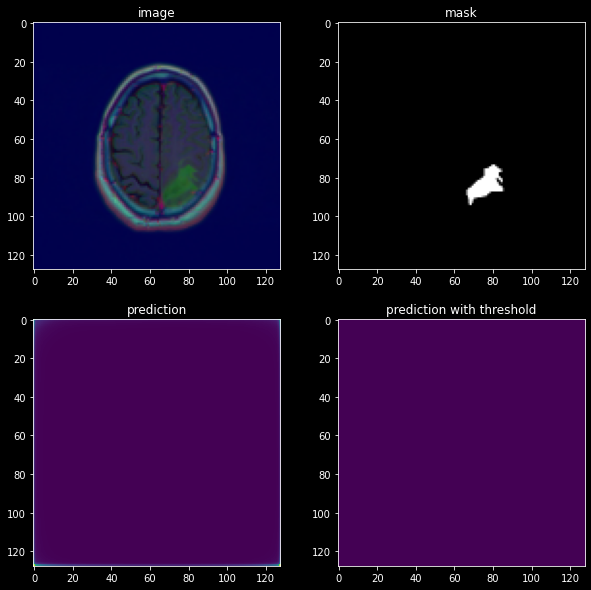

In [63]:
test_sample = test_df[test_df["diagnosis"] == 1].sample(1).values[0]
image = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

#mask
mask = cv2.resize(cv2.imread(test_sample[2]), (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = unet(pred.to(device))
pred = pred.detach().cpu().numpy()[0, 0, :, :]

pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.0
pred_t = pred_t.astype("uint8")

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")

ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")

ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")

ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")

plt.show()

# FPN: Test on the Data

In [64]:
test_iou = compute_iou(fpn, test_dataloader)
print(f"""FPN\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")

FPN
Mean IoU of the test images - 74.0%


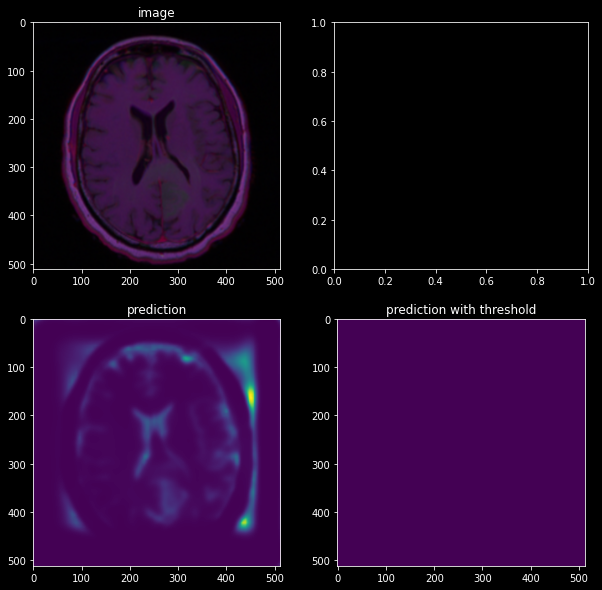

In [65]:
test_sample = test_df[test_df["diagnosis"] == 1].sample(1).values[0]

image = cv2.resize(cv2.imread(test_sample[1]), (IMG_SIZE, IMG_SIZE))
mask = cv2.resize(cv2.imread(test_sample[2]), (IMG_SIZE, IMG_SIZE))

pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = fpn(pred.to(device))
pred = pred.detach().cpu().numpy()[0, 0, :, :]

pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t > 0.3)] = 255.0
pred_t = pred_t.astype("uint8")

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")

ax[1, 0].imshow(mask)
ax[1, 0].set_title("mask")

ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")

ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")

plt.show()

# ResNeXtUNet: Test on Data

In [66]:
test_iou = compute_iou(resnextunet, test_dataloader)
print(f"""ResNeXtUNet\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")

ResNeXtUNet
Mean IoU of the test images - 91.0%


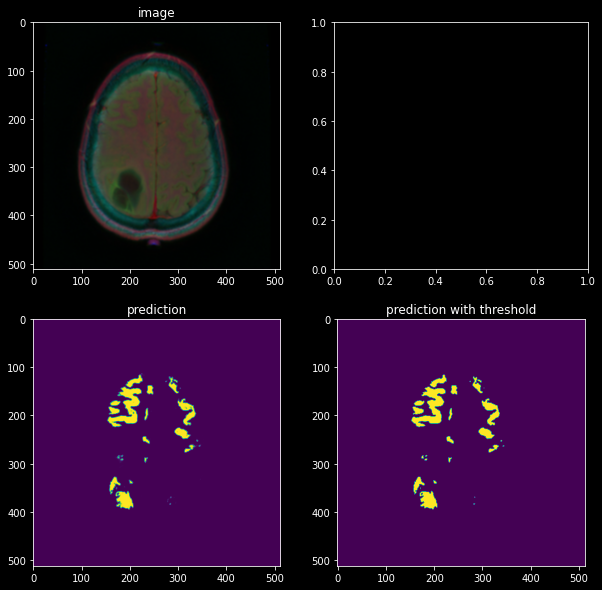

In [67]:
test_sample = test_df[test_df["diagnosis"] == 1].sample(1).values[0]

image = cv2.resize(cv2.imread(test_sample[1]), (IMG_SIZE, IMG_SIZE))
mask = cv2.resize(cv2.imread(test_sample[2]), (IMG_SIZE, IMG_SIZE))

pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = resnextunet(pred.to(device))
pred = pred.detach().cpu().numpy()[0, 0, :, :]

pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t > 0.3)] = 255.0
pred_t = pred_t.astype("uint8")

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")

ax[1, 0].imshow(mask)
ax[1, 0].set_title("mask")

ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")

ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")

plt.show()